In [29]:
"""
Read VIIRS active fire geolocation data (VNP03IMG)
Author: maxwell.cook@colorado.edu
"""

# Import packages
import sys, os
import xarray as xr
import pyproj
import geopandas as gpd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from netCDF4 import Dataset # to open NetCDF
from datetime import datetime
from datetime import timedelta
from matplotlib import pyplot as plt
from affine import Affine
from osgeo import gdal, gdal_array, gdalconst, osr
from rasterio.transform import from_bounds
from scipy.spatial import cKDTree

# Custom functions
sys.path.append(os.path.join(os.getcwd(),'code/'))
from __functions import *

# Projection information
geog = 'EPSG:4326'  # Geographic projection
prj = 'EPSG:5070'  # Projected coordinate system- WGS 84 NAD83 UTM Zone 13N

# File path information
maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')
# Output directories
dataraw = os.path.join(projdir,'data/spatial/raw/VIIRS/')
datamod = os.path.join(projdir,'data/spatial/mod/VIIRS/')

# File path information
print("Ready !")

Ready !


In [31]:
# Load the combined MODIS and VIIRS AFDs (buffered)
fp = os.path.join(datamod,'vnp14img_geo_aspen-fires-srm.csv')
afds = pd.read_csv(fp).reset_index(drop=True)
afds.columns

Index(['Unnamed: 0', 'longitude', 'latitude', 'fire_mask', 'confidence',
       'daynight', 'acq_date', 'acq_time', 'granule_id', 'geo_id', 'frp',
       'iot4', 'iot5', 'sample', 'along_scan', 'along_track', 'scan_angle',
       'pix_area'],
      dtype='object')

In [32]:
afds = afds.loc[:, ~afds.columns.str.startswith('Unnamed:')]
afds.head()

,longitude,latitude,fire_mask,confidence,daynight,acq_date,acq_time,granule_id,geo_id,frp,iot4,iot5,sample,along_scan,along_track,scan_angle,pix_area
0,-104.60649,38.234726,8,n,Night,6/1/2018,824,VNP14IMG.A2018152.0824.002.2024080110710.nc,VNP03IMG.A2018152.0824,1.722382,304.330841,289.700226,2034,0.565906,0.431471,31.1069,0.244172
1,-104.60698,38.232952,8,n,Night,6/1/2018,824,VNP14IMG.A2018152.0824.002.2024080110710.nc,VNP03IMG.A2018152.0824,2.177278,301.303925,288.965240,2035,0.565492,0.431327,31.0802,0.243912
2,-104.95000,36.581818,8,n,Night,6/1/2018,824,VNP14IMG.A2018152.0824.002.2024080110710.nc,VNP03IMG.A2018152.0824,1.447277,296.990814,286.114716,2040,0.563433,0.430609,30.9468,0.242619
3,-104.94370,36.581154,8,n,Night,6/1/2018,824,VNP14IMG.A2018152.0824.002.2024080110710.nc,VNP03IMG.A2018152.0824,1.447277,298.897369,287.142731,2041,0.563024,0.430467,30.9202,0.242363
4,-104.99421,36.582436,8,n,Night,6/1/2018,824,VNP14IMG.A2018152.0824.002.2024080110710.nc,VNP03IMG.A2018152.0824,4.948321,323.709015,290.587463,2033,0.566321,0.431616,31.1336,0.244433


In [33]:
len(afds)

27856

In [21]:
# Set up swath_gdf with original points
from shapely.geometry import Point
afds['geometry'] = [Point(xy) for xy in zip(afds.longitude, afds.latitude)]
pix_gdf = gpd.GeoDataFrame(afds, geometry='geometry', crs="EPSG:4326")

# Reproject to a projected CRS for accurate buffering
pix_gdf = pix_gdf.to_crs("EPSG:5070")

# Define the pixel buffer function for the given width and height
def pixel_buffer(point, width, height):
    half_width = width / 2
    half_height = height / 2
    return box(
        point.x - half_width, point.y - half_height,
        point.x + half_width, point.y + half_height
    )

# Apply the buffer function with along_scan and along_track values converted to meters
pix_gdf["geometry"] = pix_gdf.apply(
    lambda row: pixel_buffer(row["geometry"], row["along_scan"] * 1000, row["along_track"] * 1000),
    axis=1
)

pix_gdf = pix_gdf.reset_index(drop=True)
pix_gdf['obs_id'] = pix_gdf.index # unique ID column
# swath_gdf.loc[:, 'acq_datetime'] = swath_gdf.apply(lambda row: convert_datetime(row['acq_date'], row['acq_time']), axis=1)

# swath_gdf is now a GeoDataFrame with buffered polygons in EPSG:5070
pix_gdf.head()

,longitude,latitude,fire_mask,confidence,daynight,acq_date,acq_time,granule_id,geo_id,frp,iot4,iot5,sample,along_scan,along_track,scan_angle,pix_area,geometry,obs_id
0,-105.17872,36.775480,8,n,Day,4/7/2018,2018,VNP14IMG.A2018097.2018.002.2024079174335.nc,VNP03IMG.A2018097.2018,10.256546,339.609619,292.900085,2164,0.518258,0.414428,27.63870,0.214781,"POLYGON ((-810110.453 1564558.213, -810110.453...",0
1,-108.71903,37.178677,8,n,Day,4/7/2018,2018,VNP14IMG.A2018097.2018.002.2024079174335.nc,VNP03IMG.A2018097.2018,3.388285,336.290100,290.210724,2831,0.397990,0.366603,9.84429,0.145904,"POLYGON ((-1115101.761 1645340.349, -1115101.7...",1
2,-104.87232,35.998150,8,n,Day,7/9/2018,1930,VNP14IMG.A2018190.1930.002.2024080213444.nc,VNP03IMG.A2018190.1930,4.883715,337.208527,299.619080,4379,0.571793,0.433514,31.48040,0.247880,"POLYGON ((-791229.289 1475288.717, -791229.289...",2
3,-104.87810,35.996970,8,n,Day,7/9/2018,1930,VNP14IMG.A2018190.1930.002.2024080213444.nc,VNP03IMG.A2018190.1930,7.179646,347.446838,300.784821,4380,0.572220,0.433661,31.50710,0.248149,"POLYGON ((-791755.546 1475205.236, -791755.546...",3
4,-104.88389,35.995790,8,n,Day,7/9/2018,1930,VNP14IMG.A2018190.1930.002.2024080213444.nc,VNP03IMG.A2018190.1930,7.179646,333.186096,297.808929,4381,0.572647,0.433808,31.53380,0.248419,"POLYGON ((-792282.706 1475121.872, -792282.706...",4


In [22]:
out_fp = os.path.join(datamod,'vnp14img_geo_aspen-fires-srm_pix.gpkg')
pix_gdf.to_file(out_fp)

In [23]:
# Load and tidy the fire perimeter data
fp = os.path.join(projdir,'data/spatial/mod/NIFC/nifc-ics_2018_to_2023-aspen.gpkg')
fires = gpd.read_file(fp)

# subset to Southern Rockies
fires = fires[fires['na_l3name'] == 'Southern Rockies']

# tidy the fire id and name columns
fires.rename(columns={'NIFC_ID': 'Fire_ID', 'NIFC_NAME': 'Fire_Name'}, inplace=True)
# tify the date columns
fires['DISCOVERY_DATE'] = pd.to_datetime(fires['DISCOVERY_DATE']).dt.date
fires['WF_CESSATION_DATE'] = pd.to_datetime(fires['WF_CESSATION_DATE']).dt.date

fires['NIFC_ACRES'] = fires['NIFC_ACRES'].astype(float)
fires = fires[fires['NIFC_ACRES'] > 34.749]
print(len(fires))

63


In [24]:
# Add a small buffer to wildfire perimeters
buffer_dist = 1000  # meters
fires_ = fires.copy() # make a copy of the original data
fires_['geometry'] = fires_['geometry'].buffer(buffer_dist)
print(f"Buffered fire perimeters by {buffer_dist} meters.")

Buffered fire perimeters by 1000 meters.


In [27]:
# Perform spatial join with AFDs
afds_ = gpd.sjoin(pix_gdf, fires_, how='inner', predicate='intersects')
afds_.drop(columns=['index_right'], inplace=True)
afds_.head()

,longitude,latitude,fire_mask,confidence,daynight,acq_date,acq_time,granule_id,geo_id,frp,...,WF_CESSATION_DATE,WF_CESSATION_DOY,STR_DESTROYED_TOTAL,STR_DAMAGED_TOTAL,STR_THREATENED_MAX,EVACUATION_REPORTED,PEAK_EVACUATIONS,WF_PEAK_AERIAL,WF_PEAK_PERSONNEL,na_l3name
11,-105.226860,37.620930,8,n,Night,7/10/2018,936,VNP14IMG.A2018191.0936.002.2024080215238.nc,VNP03IMG.A2018191.0936,0.655529,...,2018-07-05,186,225,225,2878,1,200,20,724.675,Southern Rockies
56,-106.653420,40.215120,8,n,Day,7/26/2018,1918,VNP14IMG.A2018207.1918.002.2024081023201.nc,VNP03IMG.A2018207.1918,3.965241,...,2018-10-01,274,1,1,280,1,250,6.5,275,Southern Rockies
57,-106.658394,40.219230,8,n,Day,7/26/2018,1918,VNP14IMG.A2018207.1918.002.2024081023201.nc,VNP03IMG.A2018207.1918,2.651940,...,2018-10-01,274,1,1,280,1,250,6.5,275,Southern Rockies
83,-106.601380,40.203440,8,n,Day,8/2/2018,1842,VNP14IMG.A2018214.1842.002.2024081042619.nc,VNP03IMG.A2018214.1842,36.130867,...,2018-10-01,274,1,1,280,1,250,6.5,275,Southern Rockies
84,-106.590410,40.215157,9,h,Day,8/2/2018,1842,VNP14IMG.A2018214.1842.002.2024081042619.nc,VNP03IMG.A2018214.1842,127.209518,...,2018-10-01,274,1,1,280,1,250,6.5,275,Southern Rockies


In [15]:
# # Subset to the Southern Rockies (for now) and VIIRS
# afds_srm = afds[afds['na_l3name'] == 'Southern Rockies'] # subset to SRM
# afds_srm = afds_srm[afds_srm['INSTRUMENT'] == 'VIIRS'] # VIIRS detections
# print(f"There are [{len(afds_srm['NIFC_ID'].unique())}/{len(afds['NIFC_ID'].unique())}] fire events in the Southern Rockies (2018-2023).")

In [16]:
# print(afds_srm['FRP'].isna().sum())

In [ ]:
# Handle duplicate observations

In [ ]:
# Case 1. Spatial overlap > 90% and the same acquisition time

In [5]:
# Find duplicates in space and time
drop_obs = set() # to store the observations we want to drop
for idx, obs in afds_srm.iterrows():
    afdID_ = obs['afdID']
    date_matches = afds_srm[
        (afds_srm['ACQ_DATETIME'] == obs['ACQ_DATETIME']) &
        (afds_srm.afdID != afdID_)
    ]
    if len(date_matches) > 0:
        for match_idx, match_obs in date_matches.iterrows():
            afdID_match = match_obs['afdID']
            # Calculate overlap
            overlap_area = obs.geometry.intersection(match_obs.geometry).area
            ratio = overlap_area / obs.geometry.area
            # Check for >50% overlap
            if ratio > 0.50:
                # Keep the one with higher FRP, mark lower FRP for removal
                if match_obs['FRP'] < obs['FRP']:
                    drop_obs.add(afdID_match)

afds_srm_c1 = afds_srm[~afds_srm['afdID'].isin(drop_obs)]
print(f"Identified a total of [{len(drop_obs)}/{len(afds_srm)}] duplicate observations.")

out_fp = os.path.join(projdir,'data/spatial/mod/VIIRS/afd_aspen-fires_Case1.gpkg')
afds_srm_c1.to_file(out_fp)
print(f"Saved to: {out_fp}")

Identified a total of [2999/64909] duplicate observations.
Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/VIIRS/afd_aspen-fires_Case1.gpkg


In [52]:
print(afds_srm_c1['FRP'].isna().sum())

0


In [ ]:
# Case 2: Greater than 50% overlap, same day, different time.

In [6]:
time_threshold = timedelta(hours=3) # search for time within 3 hours

afds_srm_c1 = afds_srm_c1.reset_index()

drop_obs = set()
for acq_date, group in afds_srm_c1.groupby('ACQ_DATE'):
    for dn in ['D','N']:
        dn_group = group[group['DAYNIGHT'] == dn].sort_values('ACQ_DATETIME')
        for idx, obs in dn_group.iterrows():
            time_matches = dn_group[
                (dn_group['ACQ_DATETIME'] > obs['ACQ_DATETIME']) &
                (dn_group['ACQ_DATETIME'] <= obs['ACQ_DATETIME'] + time_threshold) &
                (dn_group.index != idx)  # Exclude itself
            ]
            for match_idx, match_obs in time_matches.iterrows():
                # Calculate spatial overlap ratio
                overlap_area = obs.geometry.intersection(match_obs.geometry).area
                overlap_ratio = overlap_area / obs.geometry.area
                
                # Check for >50% spatial overlap
                if overlap_ratio > 0.50:
                    # Retain the highest FRP observation
                    if match_obs['FRP'] < obs['FRP']:
                        drop_obs.add(match_idx)

afds_srm_c2 = afds_srm_c1.drop(index=list(drop_obs)).reset_index(drop=True)
print(f"Identified a total of [{len(drop_obs)}/{len(afds_srm_c1)}] overlapping observations within 2 hours, separated by day/night.")

out_fp = os.path.join(projdir, 'data/spatial/mod/VIIRS/afd_aspen-fires_Case2.gpkg')
afds_srm_c2.to_file(out_fp)
print(f"Saved to: {out_fp}")

Identified a total of [1535/61910] overlapping observations within 2 hours, separated by day/night.
Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/VIIRS/afd_aspen-fires_Case2.gpkg


In [53]:
print(afds_srm_c2['FRP'].isna().sum())

0


In [ ]:
# Case 3: Classify first day of burn and secondary

In [7]:
afds_srm_c2['detection'] = 'primary' # set the first day of burn / maximum FRP
afds_srm_c3 = afds_srm_c2.sort_values(['ACQ_DATETIME']).reset_index(drop=True)
afds_srm_c3 = afds_srm_c3.reset_index(drop=True)
afds_srm_c3.drop(columns=['index'], inplace=True)

overlap_gdf = gpd.sjoin(
    afds_srm_c3, 
    afds_srm_c3, 
    how="inner", 
    predicate="intersects", 
    lsuffix="left", 
    rsuffix="right")

# Iterate over each observation in swath_gdf_c3
for idx, obs in afds_srm_c3.iterrows():
    # Filter to previous overlapping observations only
    overlapping_obs = overlap_gdf[
        (overlap_gdf['afdID_left'] == obs['afdID']) &  # Current observation
        (overlap_gdf['afdID_right'] < obs['afdID']) &  # Previous observations only
        (overlap_gdf['DAYNIGHT_right'] == obs['DAYNIGHT'])  # Same day/night cycle
    ].copy()

    # Calculate overlap ratio for each overlapping observation
    overlap_ratios = [
        obs.geometry.intersection(afds_srm_c3.loc[afds_srm_c3['afdID'] == row['afdID_right']].geometry.iloc[0]).area
        / obs.geometry.area
        for _, row in overlapping_obs.iterrows()
    ]

    # Filter to those with significant overlap (e.g., >50%)
    overlapping_obs['overlap_ratio'] = overlap_ratios
    overlapping_obs = overlapping_obs[overlapping_obs['overlap_ratio'] > 0.5]

    # If there are overlapping observations, proceed to classify
    if not overlapping_obs.empty:
        max_frp = overlapping_obs['FRP_right'].max()  # Max FRP from overlapping observations

        # Classify based on FRP comparison
        if obs['FRP'] > max_frp:
            afds_srm_c3.at[idx, 'detection'] = 'flare-up'
        else:
            afds_srm_c3.at[idx, 'detection'] = 'secondary'

out_fp = os.path.join(projdir, 'data/spatial/mod/VIIRS/afd_aspen-fires_Case3.gpkg')
afds_srm_c3.to_file(out_fp)
print(f"Saved to: {out_fp}")

Saved to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/VIIRS/afd_aspen-fires_Case3.gpkg


In [54]:
print(afds_srm_c3['FRP'].isna().sum())

0


In [55]:
afds_srm_c3['detection'].unique()

array(['primary', 'secondary', 'flare-up'], dtype=object)

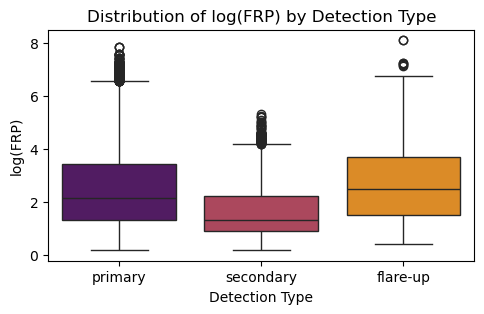

In [56]:
# Plot FRP for each detection label
plt.figure(figsize=(5.5, 3))

sns.boxplot(data=afds_srm_c3, x='detection', y='log_FRP', palette="inferno")
plt.title("Distribution of log(FRP) by Detection Type")
plt.xlabel("Detection Type")
plt.ylabel("log(FRP)")

plt.savefig(os.path.join(projdir,'figures/FigureX_Primary_Secondary-FRP.png'), dpi=150, bbox_inches='tight')

plt.show()

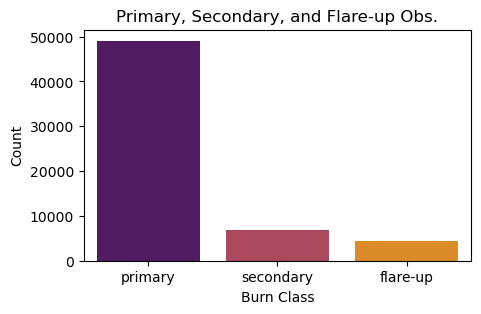

In [57]:
# Plot the distribution of "front" and "re-burn"
burn_class_counts = afds_srm_c3['detection'].value_counts()

# Plot a bar chart
plt.figure(figsize=(5, 3))
sns.barplot(x=burn_class_counts.index, y=burn_class_counts.values, palette="inferno")
plt.title("Primary, Secondary, and Flare-up Obs.")
plt.xlabel("Burn Class")
plt.ylabel("Count")

plt.savefig(os.path.join(projdir,'figures/FigureX_Primary_Secondary-Counts.png'), dpi=150, bbox_inches='tight')

plt.show()

In [61]:
len(afds_srm_c3)

60375

In [ ]:
# Join to CBI, TreeMap, etc

In [62]:
# Load the summary table (from GEE reductions)
fp = os.path.join(projdir,'data/tabular/mod/AFD/combined-afd_aspen-fires_TreeMap.csv')
treemap = pd.read_csv(fp)
treemap.drop(columns=["Unnamed: 0"], inplace=True)
print(len(treemap['afdID'].unique()))
treemap.head()

75774


,afdID,species_code,species_name,count,total_count,pct_cover,BALIVE,CANOPYPCT
0,MODIS10003,267,Grand fir,18,916,1.965066,131.977988,58.021725
1,MODIS10003,281,Lodgepole pine,152,916,16.593886,102.838687,51.568818
2,MODIS10003,901,Aspen,79,916,8.624454,74.068284,46.428982
3,MODIS10003,266,Engelmann spruce / subalpine fir,1,916,0.109170,167.405197,57.000000
4,MODIS10003,265,Engelmann spruce,2,916,0.218341,134.769196,52.000000


In [63]:
# Identify "forested" VIIRS observations
# Calculate the total forest cover percent
pct_cover_sum = treemap.groupby('afdID')['pct_cover'].sum()
# Filter afdIDs with a sum of pct_cover greater than 50%
afdIDs_gt50 = pct_cover_sum[pct_cover_sum > 50].index

# Filter the original dataframe to keep only rows with these afdIDs
treemap_ = treemap[treemap['afdID'].isin(afdIDs_gt50)]
print(f"Number of afdIDs with pct_cover > 50%: {len(afdIDs_gt50)}")

Number of afdIDs with pct_cover > 50%: 57952


In [65]:
# Identify the dominant forest type
dtree = treemap_.loc[treemap_.groupby('afdID')['pct_cover'].idxmax()]
print(len(dtree))
dtree.head()

57952


,afdID,species_code,species_name,count,total_count,pct_cover,BALIVE,CANOPYPCT
10,MODIS10003,221,Ponderosa pine,506,916,55.240175,120.826220,49.319559
20,MODIS10004,221,Ponderosa pine,591,972,60.802469,120.247868,46.442059
28,MODIS10038,281,Lodgepole pine,761,939,81.043663,123.353197,51.069535
35,MODIS10045,281,Lodgepole pine,441,607,72.652389,151.482305,39.068884
41,MODIS10046,281,Lodgepole pine,748,953,78.488982,148.898015,45.458383


In [66]:
dtree_frp = dtree.merge(afds_srm_c3, on='afdID', how='inner')
print(dtree_frp.columns)
len(dtree_frp)

Index(['afdID', 'species_code', 'species_name', 'count', 'total_count',
       'pct_cover', 'BALIVE', 'CANOPYPCT', 'LATITUDE', 'LONGITUDE',
       'BRIGHTNESS', 'SCAN', 'TRACK', 'ACQ_DATE', 'ACQ_TIME', 'SATELLITE',
       'INSTRUMENT', 'CONFIDENCE', 'VERSION', 'BRIGHT_T31', 'FRP', 'DAYNIGHT',
       'TYPE', 'VID', 'NIFC_ID', 'NIFC_NAME', 'START_YEAR', 'DISCOVERY_DATE',
       'WF_CESSATION_DATE', 'na_l3name', 'ACQ_MONTH', 'ACQ_YEAR',
       'ACQ_DATETIME', 'geometry', 'detection', 'log_FRP'],
      dtype='object')


40559

In [67]:
print(dtree_frp['FRP'].isna().sum())

0


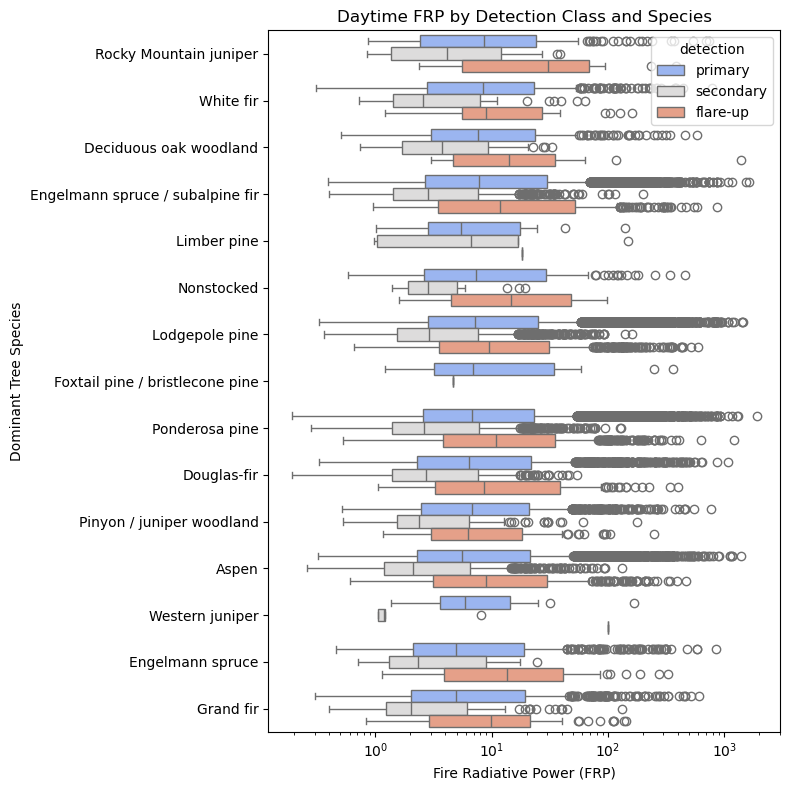

In [72]:
### Plot FRP by EVT group name
df = dtree_frp[dtree_frp['DAYNIGHT'] == 'D'] # primary obs.
df = dtree_frp

# Find the median and sort the evt classes
med = df.groupby('species_name')['FRP'].median().sort_values(ascending=False)
sorted = med.index.tolist()

plt.figure(figsize=(8, 8)) 

sns.boxplot(
    data=df,
    x='FRP', 
    y='species_name', 
    hue='detection',
    order=sorted,  
    palette='coolwarm', 
    dodge=True
)

plt.xscale('log')

plt.title('Daytime FRP by Detection Class and Species')
plt.xlabel('Fire Radiative Power (FRP)')
plt.ylabel('Dominant Tree Species')

plt.tight_layout()

plt.savefig(os.path.join(projdir,'figures/FigureX_DTree-FRP-Detections.png'), dpi=300, bbox_inches='tight')

plt.show()

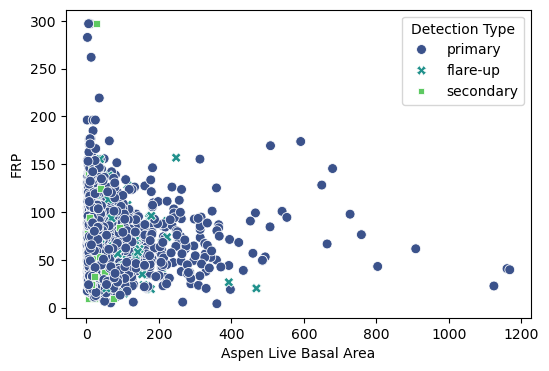

In [113]:
aspen_df = dtree_frp[dtree_frp['species_name'] == 'Aspen']
aspen_df = aspen_df[aspen_df['DAYNIGHT'] == 'D']

# Create the scatter plot
plt.figure(figsize=(6, 4))
sns.scatterplot(data=aspen_df, x='FRP', y='BALIVE', hue='detection', style='detection', s=50, palette="viridis")
plt.xlabel('Aspen Live Basal Area')
plt.ylabel('FRP')
plt.legend(title='Detection Type')

plt.savefig(os.path.join(projdir,'figures/FigureX_DTree-Aspen-FRP_scatter.png'), dpi=300, bbox_inches='tight')

plt.show()

In [73]:
# Join in the CBI
cbi = os.path.join(projdir,'data/tabular/mod/AFD/combined-afd_aspen-fires_cbi.csv')
cbi = pd.read_csv(cbi)
cbi.columns

Index(['Unnamed: 0', 'afdID', 'NIFC_ID', 'NIFC_NAME', 'START_YEAR',
       'DISCOVERY_DATE', 'WF_CESSATION_DATE', 'SATELLITE', 'INSTRUMENT',
       'ACQ_MONTH', 'ACQ_YEAR', 'ACQ_DATETIME', 'DAYNIGHT', 'FRP',
       'CBI_bc_mean', 'CBI_mean', 'rbr_mean', 'na_l3name', 'LATITUDE',
       'LONGITUDE'],
      dtype='object')

In [74]:
cbi = cbi[['afdID','CBI_mean', 'CBI_bc_mean', 'rbr_mean']]
cbi.head()

,afdID,CBI_mean,CBI_bc_mean,rbr_mean
0,MODIS7298,0.782353,0.561870,71.503814
1,MODIS7301,0.425406,0.131282,9.243563
2,MODIS7989,0.937893,0.751896,83.385192
3,MODIS7990,0.828863,0.645225,62.153224
4,MODIS7991,0.349078,0.049575,-2.606044


In [75]:
dtree_frp_cbi = dtree_frp.merge(cbi, on='afdID', how='inner')
print(len(dtree_frp_cbi))
dtree_frp_cbi.head()

41205


,afdID,species_code,species_name,count,total_count,pct_cover,BALIVE,CANOPYPCT,LATITUDE,LONGITUDE,...,na_l3name,ACQ_MONTH,ACQ_YEAR,ACQ_DATETIME,geometry,detection,log_FRP,CBI_mean,CBI_bc_mean,rbr_mean
0,VIIRS1001038,201,Douglas-fir,293,943,31.071050,74.364184,52.216879,38.439259,-109.303391,...,Southern Rockies,6,2021,2021-06-13 08:48:00+00:00,"POLYGON ((-1146313.681 1792625.263, -1146313.6...",primary,2.042518,0.847195,0.643190,86.774839
1,VIIRS1001039,201,Douglas-fir,468,988,47.368421,NaN,NaN,38.439938,-109.309196,...,Southern Rockies,6,2021,2021-06-13 08:48:00+00:00,"POLYGON ((-1146800.064 1792770.670, -1146800.0...",primary,4.253198,2.078836,2.166764,275.755901
2,VIIRS1001040,901,Aspen,213,988,21.558704,NaN,NaN,38.440643,-109.315277,...,Southern Rockies,6,2021,2021-06-13 08:48:00+00:00,"POLYGON ((-1147309.656 1792922.323, -1147309.6...",primary,4.253198,2.433062,2.591413,321.297653
3,VIIRS1001042,201,Douglas-fir,334,962,34.719335,182.454803,74.000000,38.442883,-109.302284,...,Southern Rockies,6,2021,2021-06-13 08:48:00+00:00,"POLYGON ((-1146162.230 1793014.140, -1146162.2...",primary,0.845868,0.317915,0.041044,1.961541
4,VIIRS1001043,201,Douglas-fir,459,1014,45.266272,89.442265,52.038889,38.443581,-109.308228,...,Southern Rockies,6,2021,2021-06-13 08:48:00+00:00,"POLYGON ((-1146660.193 1793163.323, -1146660.1...",primary,0.815365,1.878940,1.935497,230.284377


In [76]:
dtree_frp_cbi = dtree_frp_cbi.drop_duplicates(subset='afdID', keep='first')
len(dtree_frp_cbi)

40559

In [77]:
print(dtree_frp_cbi['afdID'].isna().sum())
print(dtree_frp_cbi['CBI_mean'].isna().sum())
print(dtree_frp_cbi['species_name'].isna().sum())
print(dtree_frp_cbi['FRP'].isna().sum())

0
0
0
0


In [ ]:
# Calculate the Pearson correlation by forest type

In [87]:
df = dtree_frp_cbi[dtree_frp_cbi['detection'] == 'primary'] #primary obs.
df = dtree_frp_cbi[dtree_frp_cbi['DAYNIGHT'] == 'D'] #daytime

In [100]:
from scipy.stats import pearsonr

correlations = {}
for tree_type, group in df.groupby('species_name'):
    corr, p_value = pearsonr(group['FRP'], group['CBI_bc_mean'])
    correlations[tree_type] = (corr, p_value)
    print(f"Tree Type: {tree_type} - Pearson correlation: {corr:.2f}, p-value: {p_value:.4f}")

Tree Type: Aspen - Pearson correlation: 0.20, p-value: 0.0000
Tree Type: Deciduous oak woodland - Pearson correlation: 0.28, p-value: 0.0002
Tree Type: Douglas-fir - Pearson correlation: 0.17, p-value: 0.0000
Tree Type: Engelmann spruce - Pearson correlation: -0.04, p-value: 0.4979
Tree Type: Engelmann spruce / subalpine fir - Pearson correlation: 0.21, p-value: 0.0000
Tree Type: Foxtail pine / bristlecone pine - Pearson correlation: 0.57, p-value: 0.1053
Tree Type: Grand fir - Pearson correlation: 0.21, p-value: 0.0005
Tree Type: Limber pine - Pearson correlation: 0.08, p-value: 0.8633
Tree Type: Lodgepole pine - Pearson correlation: 0.22, p-value: 0.0000
Tree Type: Nonstocked - Pearson correlation: 0.20, p-value: 0.0967
Tree Type: Pinyon / juniper woodland - Pearson correlation: 0.14, p-value: 0.0007
Tree Type: Ponderosa pine - Pearson correlation: 0.23, p-value: 0.0000
Tree Type: Rocky Mountain juniper - Pearson correlation: 0.31, p-value: 0.0004
Tree Type: Western juniper - Pearson

In [108]:
correlation_df = pd.DataFrame(correlations, index=['correlation', 'p_value']).T
print("\nCorrelation by Tree Type:\n")
correlation_df = correlation_df.sort_values('correlation')
correlation_df.to_csv(os.path.join(projdir, 'data/tabular/mod/afds_aspen-fires_frp-cbi_pearson.csv'))
correlation_df.head(15)


Correlation by Tree Type:



,correlation,p_value
Western juniper,-0.059089,8.409711e-01
Engelmann spruce,-0.042723,4.978754e-01
Limber pine,0.080813,8.632552e-01
White fir,0.142739,3.313072e-02
Pinyon / juniper woodland,0.143199,6.696769e-04
Douglas-fir,0.168775,2.153418e-07
Aspen,0.195132,1.228784e-19
Nonstocked,0.203090,9.670610e-02
Engelmann spruce / subalpine fir,0.210086,2.243198e-25
Grand fir,0.211188,4.538677e-04


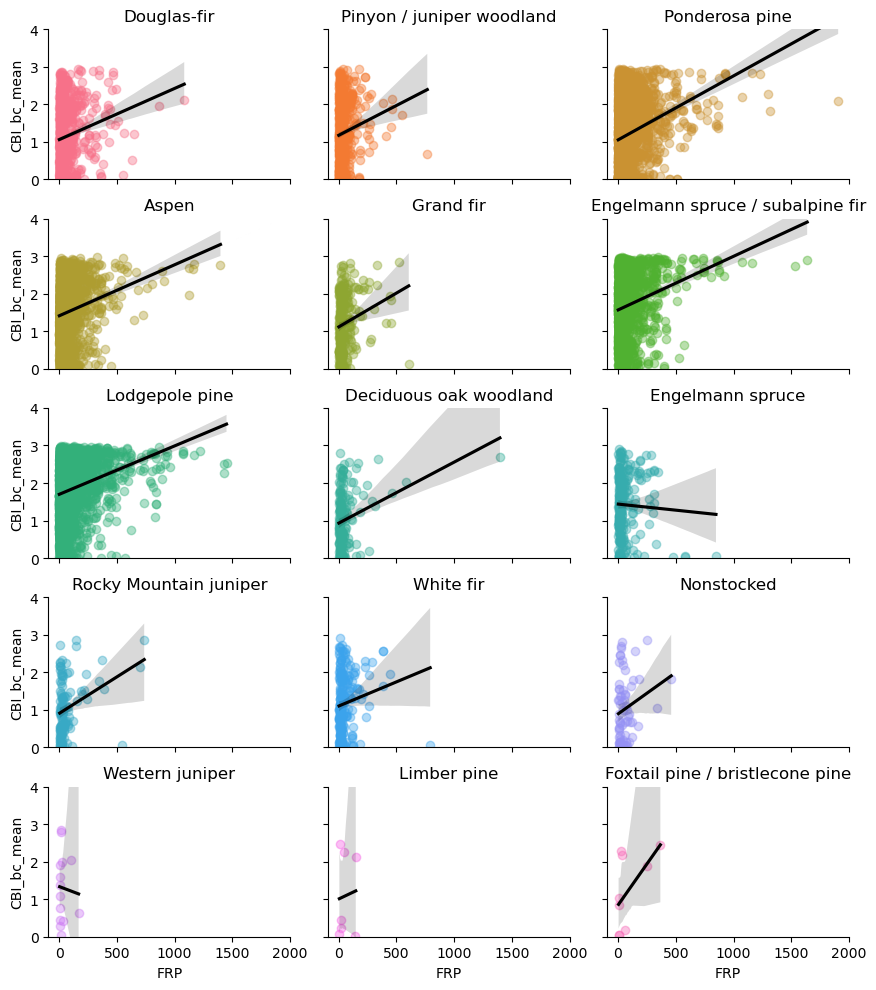

In [106]:
g = sns.lmplot(data=df, x='FRP', y='CBI_bc_mean', hue='species_name', col='species_name', 
           col_wrap=3, height=2, aspect=1.5, scatter_kws={'alpha':0.4}, line_kws={'color':'black'}, sharey=True
          )

# Adjust the titles to remove the "species_name = " prefix
for ax in g.axes.flat:
    ax.set_ylim(0, 4)  # Set the y-axis limit from 0 to 4
    ax.set_title(ax.get_title().replace('species_name = ', ''))

plt.savefig(os.path.join(projdir,'figures/FigureX_DTree-FRP-CBI_bc.png'), dpi=300, bbox_inches='tight')

plt.show()